# Straight vs Bent Rays

In this notebook we compare straight vs bent rays for a synthetic cross-borehole example.

In [1]:
from enum import StrEnum, auto
from functools import partial
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray
import pyfm2d
from octo.basis import BaseBasis, CosineBasis2D
from scipy.sparse import coo_matrix, csr_matrix
from scipy.stats import multivariate_normal

/Users/eart0665/Documents/Oxford/Work/harmtransc/.venv/lib/python3.12/site-packages/pyfm2d/wavetracker.py:4: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.2)
  from scipy.interpolate import RectBivariateSpline


## Create Synthetic Dataset

The true velocity model is a couple of Gaussians.

In [2]:
def get_gauss_model(
    extent: list[float], nx: int, ny: int
):
    # Velocities
    vc1 = 1700
    vc2 = 2300
    vb = 2000

    # Grid setup
    xc = np.linspace(extent[0], extent[1], nx)
    yc = np.linspace(extent[2], extent[3], ny)
    X, Y = np.meshgrid(xc, yc, indexing="ij")

    # Gaussian centers and spreads
    dex = extent[1] - extent[0]
    dey = extent[3] - extent[2]
    center1_x = extent[0] + (7.0 - extent[0]) * dex / 20.0
    center1_y = extent[0] + (22.0 - extent[0]) * dey / 30.0
    center2_x = extent[0] + (12.0 - extent[0]) * dex / 20.0
    center2_y = extent[0] + (10.0 - extent[0]) * dey / 30.0
    sigma1 = 6.0 * dex / 20.0
    sigma2 = 10.0 * dex / 20.0

    # Multivariate normals
    rv1 = multivariate_normal([center1_x, center1_y], [[sigma1, 0], [0, sigma1]])
    rv2 = multivariate_normal([center2_x, center2_y], [[sigma2, 0], [0, sigma2]])

    # Probability densities
    pos = np.stack((X, Y), axis=-1)
    gauss1 = rv1.pdf(pos)
    gauss2 = rv2.pdf(pos)

    # Model
    model = vb * np.ones([nx, ny])
    model += (vc1 - vb) * gauss1 / np.max(gauss1)
    model += (vc2 - vb) * gauss2 / np.max(gauss2)
    return model


In [3]:
extent = [0.0, 20.0, 0.0, 30.0]
m = get_gauss_model(extent, 32, 48)
g2 = pyfm2d.BasisModel(m, extent=extent)
velocity = g2.get_velocity()

Create some sources and receivers either side of the borehole.

In [4]:
receivers = pyfm2d.wavetracker.generate_surface_points(
    10, extent=extent, surface=[False, True, False, False], addCorners=False
)
sources = pyfm2d.wavetracker.generate_surface_points(
    10, extent=extent, surface=[True, False, False, False], addCorners=False
)
nr = len(receivers)  # number of receivers
ns = len(sources)  # number of sources

Calculate the travel times to create the synthetic dataset (and ray paths for visualisation)

In [5]:
options = pyfm2d.WaveTrackerOptions(times=True, paths=True)
result = pyfm2d.calc_wavefronts(
    velocity, receivers, sources, nthreads=8, extent=extent, options=options
)

/Users/eart0665/Documents/Oxford/Work/harmtransc/.venv/lib/python3.12/site-packages/pyfm2d/wavetracker.py:4: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.2)
  from scipy.interpolate import RectBivariateSpline
/Users/eart0665/Documents/Oxford/Work/harmtransc/.venv/lib/python3.12/site-packages/pyfm2d/wavetracker.py:4: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.2)
  from scipy.interpolate import RectBivariateSpline
/Users/eart0665/Documents/Oxford/Work/harmtransc/.venv/lib/python3.12/site-packages/pyfm2d/wavetracker.py:4: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.2)
  from scipy.interpolate import RectBivariateSpline
/Users/eart0665/Documents/Oxford/Work/harmtransc/.venv/lib/python3.12/site-packages/pyfm2d/wavetracker.py:4: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this ve

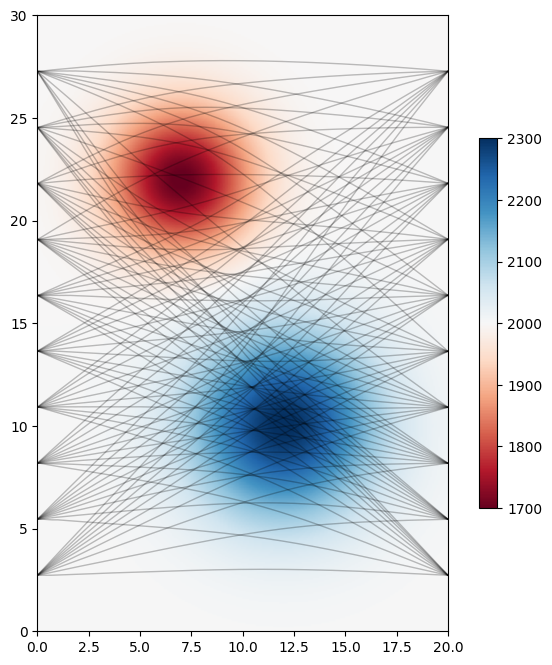

In [6]:
pyfm2d.display_model(velocity, extent=extent, figsize=(8, 8), clim=(1700, 2300), paths=result.paths, alpha=0.25)

Add some random noise of known covariance.

Text(0, 0.5, 'Travel Time')

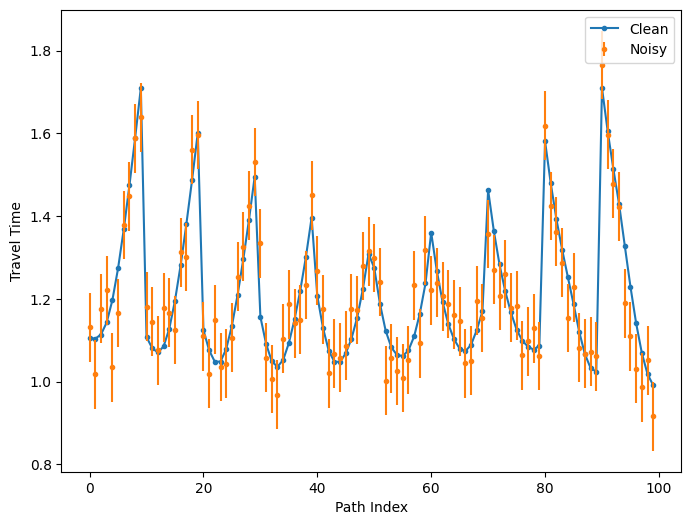

In [7]:
rng = np.random.default_rng(42)
std = 0.5 * np.std(result.ttimes)
d_obs = result.ttimes + rng.normal(0, std, result.ttimes.shape)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(result.ttimes, marker=".", label="Clean")
ax.errorbar(np.arange(len(d_obs)), d_obs, yerr=std, fmt=".", label="Noisy")
ax.legend()
ax.set_xlabel("Path Index")
ax.set_ylabel("Travel Time")

## Velocity Field Parameterisation

The velocity field will be parameterised with 2D cosine basis functions.  We'll assume fairly large-scale structure.

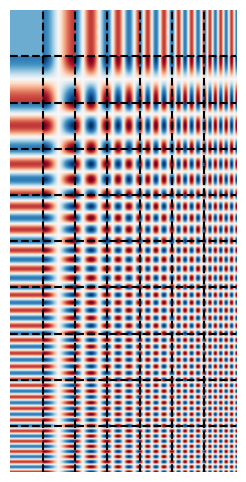

In [8]:
nx = 7
ny = 10
basis = CosineBasis2D(Nx=nx, Ny=ny)
basis.plot(figsize=(8, 6))

## Define the competing forward models

For the bent rays we use `pyfm2d`.

In [9]:
class BentRayForwardModel:
    def __init__(
        self,
        sources: NDArray[np.float64],
        receivers: NDArray[np.float64],
        basis: BaseBasis,
        extent: list[float],
        n_threads: int = 8,
    ):
        self.receivers = receivers
        self.sources = sources
        self.basis = basis
        self.extent = extent
        self.n_threads = n_threads
        self.wavetracker_options = pyfm2d.WaveTrackerOptions()

    def __call__(
        self, x: NDArray[np.float64]
    ) -> NDArray[np.float64]:
        """
        Evaluate the forward model at the given coefficients.
        """
        # Create a velocity model from the coefficients
        model = self.basis(x)
        # Calculate wavefronts
        result = pyfm2d.calc_wavefronts(
            model,
            self.receivers,
            self.sources,
            nthreads=self.n_threads,
            extent=self.extent,
            options=self.wavetracker_options,
        )
        return result.ttimes

In [10]:
bent_fm = BentRayForwardModel(
    sources,
    receivers,
    basis,
    extent,
)

For the straight ways we create a matrix representing the path travelled.  Each row in the matrix is a path.

In [11]:
basis

In [12]:
def line_grid_distances(
    starts: NDArray[np.float64],
    ends: NDArray[np.float64],
    grid_shape: tuple[int, int],  # (rows, cols)
    extent: list[float],
    step: float = 0.01,
) -> csr_matrix:
    rows, cols = grid_shape
    x_min, x_max, y_min, y_max = extent
    cell_w = (x_max - x_min) / cols
    cell_h = (y_max - y_min) / rows

    N = starts.shape[0]
    M = ends.shape[0]
    K = N * M  # total number of paths

    # All (N, M, 2) start-end combinations
    starts_exp = starts[:, None, :]  # (N, 1, 2)
    ends_exp = ends[None, :, :]  # (1, M, 2)
    start_pts = np.broadcast_to(starts_exp, (N, M, 2))
    end_pts = np.broadcast_to(ends_exp, (N, M, 2))

    dx = end_pts[..., 0] - start_pts[..., 0]
    dy = end_pts[..., 1] - start_pts[..., 1]
    total_dists = np.hypot(dx, dy)
    num_steps = np.maximum((total_dists / step).astype(int), 1)
    max_steps = np.max(num_steps)

    # Sample points along the line
    t_vals = np.linspace(0, 1, max_steps + 1)[:, None, None, None]  # (T, 1, 1, 1)
    start_pts_exp = start_pts[None, ...]  # (1, N, M, 2)
    end_pts_exp = end_pts[None, ...]
    positions = start_pts_exp + t_vals * (end_pts_exp - start_pts_exp)  # (T, N, M, 2)

    # Segment data
    seg_start = positions[:-1]
    seg_end = positions[1:]
    seg_lengths = np.hypot(
        seg_end[..., 0] - seg_start[..., 0], seg_end[..., 1] - seg_start[..., 1]
    )  # (T-1, N, M)

    seg_x = seg_start[..., 0]
    seg_y = seg_start[..., 1]
    cell_x = ((seg_x - x_min) / cell_w).astype(int)
    cell_y = ((seg_y - y_min) / cell_h).astype(int)

    valid = (cell_x >= 0) & (cell_x < cols) & (cell_y >= 0) & (cell_y < rows)

    # Flatten: T-1, N, M → (T-1)*K
    T1 = seg_lengths.shape[0]
    seg_lengths_flat = seg_lengths.reshape(-1)
    cell_x_flat = cell_x.reshape(-1)
    cell_y_flat = cell_y.reshape(-1)
    valid_flat = valid.reshape(-1)

    path_ids = np.tile(np.arange(K), T1)  # (T1*K,)
    cell_ids = cell_y_flat * cols + cell_x_flat  # flattened cell index per segment

    # Mask invalid entries
    path_ids = path_ids[valid_flat]
    cell_ids = cell_ids[valid_flat]
    seg_lengths_flat = seg_lengths_flat[valid_flat]

    # Output: (K, rows*cols)
    result = coo_matrix(
        (seg_lengths_flat, (path_ids, cell_ids)),
        shape=(K, rows * cols),
    ).tocsr()
    return result


class StraightRayForwardModel:
    def __init__(
        self,
        sources: NDArray[np.float64],
        receivers: NDArray[np.float64],
        basis: BaseBasis,
        extent: list[float],
    ):
        self.receivers = receivers
        self.sources = sources
        self.extent = extent
        self.basis = basis
        self.grid_shape = (self.basis.Ny, self.basis.Nx)

        self.path_matrix = line_grid_distances(
            sources,
            receivers,
            grid_shape=self.grid_shape,
            extent=extent,
        )

    def __call__(
        self, x: NDArray[np.float64]
    ) -> NDArray[np.float64]:
        return self.path_matrix @ self.basis(x)

    def plot(self) -> None:
        pm = self.path_matrix.toarray()
        fig, ax = plt.subplots()
        cax = ax.imshow(pm)
        ax.set_title("Path Matrix")
        ax.set_ylabel("Path Index")
        ax.set_xlabel("Cell Index")
        fig.colorbar(cax, label="Path length in grid cells")

    def plot_path(self, path_index: int) -> None:
        pm = self.path_matrix.toarray()
        source_index, receiver_index = np.unravel_index(
            path_index, (self.sources.shape[0], self.receivers.shape[0])
        )
        fig, ax = plt.subplots()
        cax = ax.imshow(
            pm[path_index].reshape(self.grid_shape),
            extent=self.extent,
            origin="lower",
        )
        ax.scatter(
            self.sources[source_index, 0],
            self.sources[source_index, 1],
            color="red",
            marker="*",
            s=100,
            label="Source",
        )
        ax.scatter(
            self.receivers[receiver_index, 0],
            self.receivers[receiver_index, 1],
            color="blue",
            marker="^",
            s=100,
            label="Receiver",
        )
        ax.set_title(f"Path {path_index}")
        ax.set_ylabel("y")
        ax.set_xlabel("x")
        fig.colorbar(cax, label="Path length in grid cells")


Visualise the path matrix

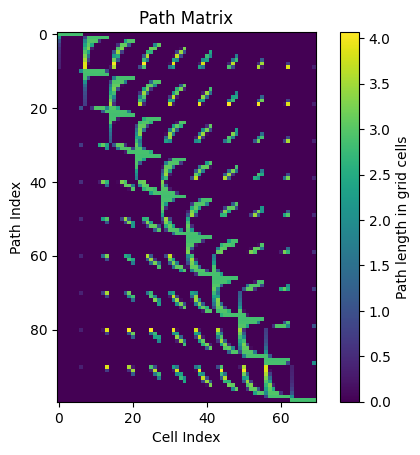

In [13]:
straight_fm = StraightRayForwardModel(
    sources,
    receivers,
    basis,
    extent,
)
straight_fm.plot()

Check a path

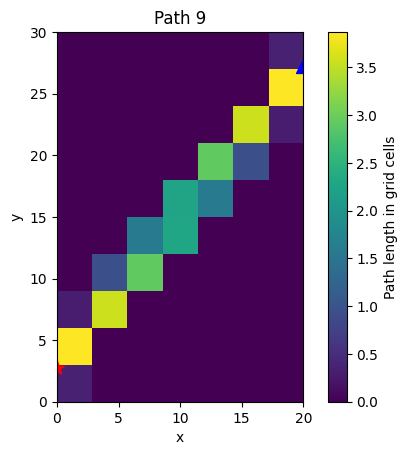

In [14]:
straight_fm.plot_path(9)

In [15]:
class ForwardModels(StrEnum):
    BENT = auto()
    STRAIGHT = auto()


forward_models: dict[
    ForwardModels,
    Callable[[NDArray[np.float64]], NDArray[np.float64]],
] = {
    ForwardModels.BENT: bent_fm,
    ForwardModels.STRAIGHT: straight_fm,
}

## Define the Posterior

In [16]:
def log_prior(x: NDArray[np.float64]) -> float:
    """
    Uniform log prior probability density function.

    We'll put a tight prior around the background mean x[0]
    just to make things a bit easier.
    """
    if not (1950 < x[0] < 2050):
        return -np.inf
    if not np.all((-10 < x[1:]) & (x[1:] < 10)):
        return -np.inf
    return 0.0


def log_likelihood(
    x: NDArray[np.float64],
    model: ForwardModels,
    data: NDArray[np.float64],
    inv_covariance: NDArray[np.float64],
) -> float:
    """
    Log likelihood function for the observed data given the model parameters.
    """
    predicted = forward_models[model](x)
    residual = data - predicted
    return -0.5 * residual.T @ inv_covariance @ residual


_log_likelihood = partial(
    log_likelihood, data=d_obs, inv_covariance=(1 / std**2) * np.eye(len(d_obs))
)
log_likelihoods: dict[ForwardModels, Callable[[NDArray[np.float64]], float]] = {
    model: partial(_log_likelihood, model=model) for model in ForwardModels
}


def log_posterior(x: NDArray[np.float64], model: ForwardModels) -> float:
    """
    Log posterior probability density function.
    """
    if (lp := log_prior(x)) == -np.inf:
        return lp
    ll = log_likelihoods[model](x)
    return lp + ll